<a href="https://colab.research.google.com/github/joez2103/MusicalCompGen/blob/main/Musical_Composition_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Musical Composition Generator**
This application allows you to generate a musical composition in the MIDI format based on a MIDI file input into the application. This creates new musical compositions based on existing musical compositions.

A machine learning model known as a recurrent neural network (RNN), which is a type of supervised learning algorithm, has been trained on an extensive classical MIDI dataset in order to generate new musical compositions based on your input. The details of the code behind training this machine learning model, as well as visualizations for the data output by the model are below.

# **Setup and Data Import**
This section details setting up the application and importing the data used to train the recurrent neural network (RNN).

First, several libraries are installed and imported in order to perform functions such as: representing the data (NumPy); parsing the MIDI data into values suitable for machine learning and parsing the generative output back into MIDI (PrettyMIDI); creating the machine learning model (TensorFlow Keras); and playing the generated MIDI within the application to easily hear the results (PFluidSynth).

Click the "Connect" button at the top-right of the Colab interface, then run each of the code cells below in order to ensure all appropriate applications and libraries are installed.

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

Next, run the code below to set the random seed for both TensorFlow and NumPy, as well as the sampling rate for audio playback.

In [5]:
seed = 37
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000

Now import the Maestro MIDI dataset, a collection of MIDI captured from top pianists playing classical music. This dataset will be brought into the "filenames" list to be further parsed and prepped.

In [6]:
data_dir = pathlib.Path('data/maestro-v3.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v3.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

filenames = glob.glob(str(data_dir/'**/*.mid*'))

for f in filenames[:1]:
  print(f)

58416533/58416533 [==============================] - 1s 0us/step
data/maestro-v3.0.0/2017/MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--5.midi


# **Create MIDI Parsing Functions**

This section sets up a function which can turn MIDI data into note data suitable for processing by the recurrent neural network (RNN) model. It also definses a function which can turn the note data generated by the RNN model back into MIDI data, suitable for generating audio previews within this application, or downloading for further processing in a digital audio workstation (DAW).

Run each function definition below in order to ensure these functions are usable later in the application.

First, define the MIDI to notes function so the MIDI files in the dataset can be processed by the RNN model.

In [13]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

Now define the notes to MIDI function so the numeric note information output by the RNN model can be turned back into a MIDI file.

In [14]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

# **Prepare the Dataset**

This section details preparing the files from the Maestro MIDI dataset into a dataset ready to be input into the machine learning model.

Run each of the items below to prepare the dataset.

First, you can see the number of files from the Maestro MIDI dataset below.

In [15]:
print('Number of files:', len(filenames))

Number of files: 1276


Now set the number of files that will be used to train the dataset. Run the code below to set the number of files to the suggested amount of 5.

In [16]:
num_files = 5

Next, extract the note data from all of the MIDI files. This may take a minute.

In [17]:
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)

Now create the dataset that will be run through the machine learning model, starting with defining the key values the model will use: note pitch, step, and duration.

In [18]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

The dataset will use sequences of notes parsed from the MIDI data, with the goal of the RNN model being to predict the next note in the sequence. Run the module below in order to define how a sequence is created, create the sequences, and create the dataset that will be run through the model.

In [57]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.59375    0.         0.2201255 ]
 [0.5859375  0.1949683  0.2075469 ]
 [0.59375    0.20440225 0.2201255 ]
 [0.5859375  0.17295575 0.19182365]
 [0.59375    0.18553435 0.23584875]
 [0.5546875  0.18553435 0.20440225]
 [0.578125   0.1823897  0.188679  ]
 [0.5625     0.19182365 0.23584875]
 [0.5390625  0.19811295 0.46855285]
 [0.46875    0.55660305 0.1572325 ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.18238969999999988>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.22012549999999997>}


(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [58]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [59]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.59375    0.         0.2201255 ]
 [0.5859375  0.1949683  0.2075469 ]
 [0.59375    0.20440225 0.2201255 ]
 [0.5859375  0.17295575 0.19182365]
 [0.59375    0.18553435 0.23584875]
 [0.5546875  0.18553435 0.20440225]
 [0.578125   0.1823897  0.188679  ]
 [0.5625     0.19182365 0.23584875]
 [0.5390625  0.19811295 0.46855285]
 [0.46875    0.55660305 0.1572325 ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.18238969999999988>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.22012549999999997>}


(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# **Training the Recurrent Neural Network (RNN) Model**

This section details using the Maestro MIDI dataset to train the recurrent neural network (RNN) to generate new, musical MIDI data. This involves defining the model and using the prepared dataset from the previous section to train the model.

First, run the module below to define a custom mean squared error loss function that encourages positive note values to be output by the model, as well as to define the inputs, outputs, and other parameters for the model.

In [22]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Next, run the two modules below to train the model over 50 epochs, or cycles. **Note this can take up to 10 minutes to run.**

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Finally, run the plot functions below to see how the mean squared error loss function, which shows how accurate the model's predictions are, changed while training the model over 50 epochs.

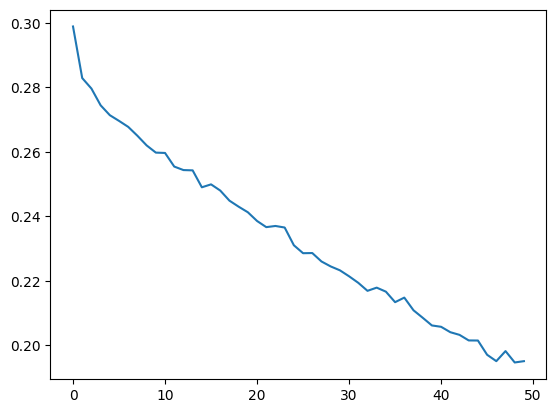

In [25]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# **Use the Trained RNN Model to Predict Notes from an Input MIDI File**

This section details importing a new MIDI file of your choice, and generating a brand new MIDI file by running the imported MIDI file through the trained RNN model.

First, get the URL of a MIDI file you would like to input. Classical piano MIDI files will work best since the model is trained on similar works. I reccomend using MIDI files from the MIDI World website, specifically the classical section linked below:

https://www.midiworld.com/classic.htm

Find a link to a MIDI file on the site, copy it, and paste the URL within the quotes for the URL value, paste the filename itself within the quotes for the input filename value, then run both modules below. You can also simply run the modules below as-is to use a default MIDI file input, which is Beethoven's "Fur Elise."

In [26]:
input_midi_url = 'https://www.midiworld.com/midis/other/beethoven/furelise.mid'
input_midi_filename = 'furelise.mid'

In [33]:
data_dir2 = pathlib.Path('data/inputmidi')
if not data_dir2.exists():
  tf.keras.utils.get_file(
      input_midi_filename,
      input_midi_url,
      extract=True,
      cache_dir='./data', cache_subdir='inputmidi',
  )

input_midi_file = str(data_dir2) + '/' + input_midi_filename
print(input_midi_file)

midi_input_notes = midi_to_notes(input_midi_file)
midi_input_notes.head()

data/inputmidi/furelise.mid


,pitch,start,end,step,duration
0,76,0.738993,0.959118,0.000000,0.220125
1,75,0.933961,1.141508,0.194968,0.207547
2,76,1.138363,1.358489,0.204402,0.220126
3,75,1.311319,1.503143,0.172956,0.191824
4,76,1.496853,1.732702,0.185534,0.235849


Now run the module below to define how notes will be predicted using the model.

In [35]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Finally, run the module below to predict notes based off the input MIDI file using the trained RNN model.

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([midi_input_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

# **Evaluating the Results**

This section goes over the original input MIDI file, and the generated MIDI output. You can listen to each MIDI file played through a virtual piano here, as well as see some visualizations regarding accuracy and comparing the two files.

Run the module below, then press the play button once the audio player appears to hear a 1 minute preview of the original MIDI file as played on a virtual piano.

In [40]:
pm = pretty_midi.PrettyMIDI(input_midi_file)

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=60):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

Now run the module below, then press the play button on the audio player to hear a preview of the generated MIDI file as played on a virtual piano.

In [45]:
out_file = 'generated.mid'

instrument_name = 'Acoustic Grand Piano'

out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

display_audio(out_pm)

Run the module below to evaluate the mean squared error loss function, which measures accuracy, on the generated MIDI file.

In [66]:
key_order = ['pitch', 'step', 'duration']
input_notes = np.stack([midi_input_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(input_notes)
notes_ds.element_spec

seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
input_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

input_ds.element_spec

print('The mean squared error loss for the input MIDI file is ' + str(model.evaluate(input_ds, return_dict=True)['loss']))

9/9 [==============================] - 0s 23ms/step - loss: 0.2460 - duration_loss: 0.0386 - pitch_loss: 3.5080 - step_loss: 0.0320
The mean squared error loss for the input MIDI file is 0.24602577090263367


Run the module below to see the distribution for the pitch, step, and duration values of the input MIDI file.

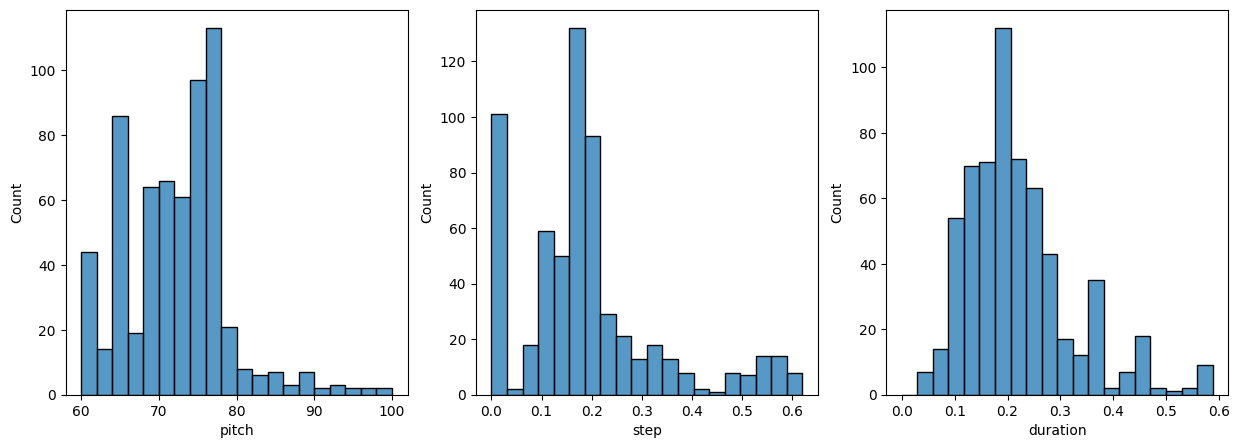

In [67]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

plot_distributions(midi_input_notes)

Finally, run the module below to see the same distributions for the generated MIDI file.

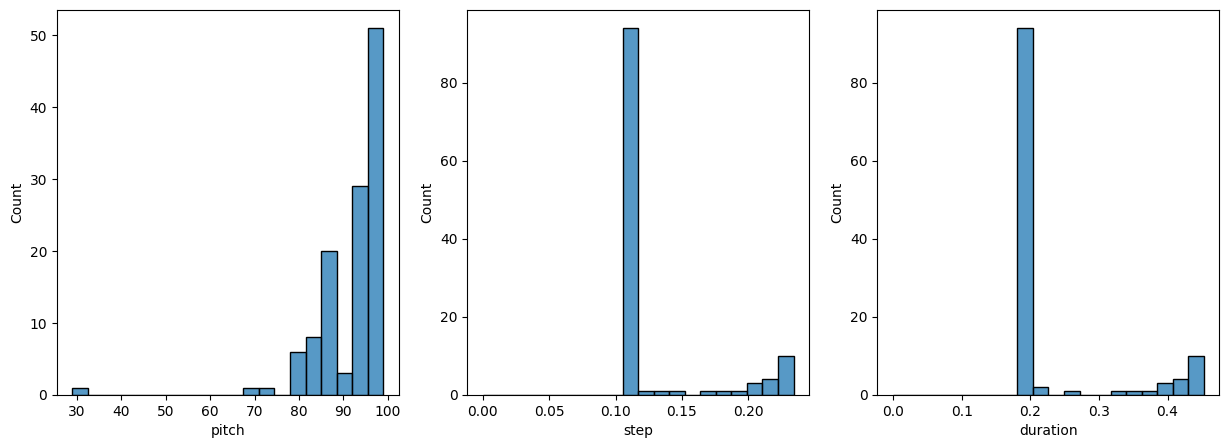

In [68]:
plot_distributions(generated_notes)